In [1]:
# Set directories
base_dir = '/home/vaibhavpawar/codes/kaggle/personalized_medicine/'
raw_data_dir = base_dir + 'raw_data/'
pro_data_dir = base_dir + 'processed_data/'

In [2]:
import pandas as pd
import numpy as np

In [3]:
train_variant = pd.read_csv(raw_data_dir + 'training_variants')
test_variant = pd.read_csv(raw_data_dir + 'test_variants')
train_text = pd.read_csv(raw_data_dir + 'training_text', sep='\|\|', engine='python', 
                         header=None, skiprows=1, names=['ID','Text'])
test_text = pd.read_csv(raw_data_dir + 'test_text', sep='\|\|', engine='python', 
                        header=None, skiprows=1, names=["ID","Text"])

In [8]:
train = pd.merge(train_variant, train_text, how='left', on='ID')
test = pd.merge(test_variant, test_text, how='left', on='ID')

In [128]:
test.head()

,ID,Gene,Variation,Text
0,0,ACSL4,R570S,2. This mutation resulted in a myeloproliferat...
1,1,NAGLU,P521L,Abstract The Large Tumor Suppressor 1 (LATS1)...
2,2,PAH,L333F,Vascular endothelial growth factor receptor (V...
3,3,ING1,A148D,Inflammatory myofibroblastic tumor (IMT) is a ...
4,4,TMEM216,G77A,Abstract Retinoblastoma is a pediatric retina...


In [129]:
tr_genes_not_found = []
tr_variations_not_found = []
ts_genes_not_found = []
ts_variations_not_found = []

for i, row in enumerate(train.itertuples()):
    if row.Gene not in row.Text:
        tr_genes_not_found.append(str(row.ID) + ':' + row.Gene)
    if row.Variation not in row.Text:
        tr_variations_not_found.append(str(row.ID) + ':' + row.Variation)
        
for i, row in enumerate(test.itertuples()):
    if row.Gene not in row.Text:
        ts_genes_not_found.append(str(row.ID) + ':' + row.Gene)
    if row.Variation not in row.Text:
        ts_variations_not_found.append(str(row.ID) + ':' + row.Variation)

In [131]:
print len(tr_genes_not_found)
print len(tr_variations_not_found)
print len(ts_genes_not_found)
print len(ts_variations_not_found)

370
1077
5227
127


In [141]:
tr_variations_not_found[0:10]

['0:Truncating Mutations',
 '7:Deletion',
 '16:Truncating Mutations',
 '19:Y371S',
 '41:Truncating Mutations',
 '44:T1365M',
 '46:T844M',
 '48:Promoter Hypermethylation',
 '49:R1343L',
 '61:R1209W']

In [10]:
texts = []

for row in train.itertuples():
    texts.append(row.Text)
    
for row in test.itertuples():
    texts.append(row.Text)

In [13]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [73]:
MAX_SEQUENCE_LENGTH = 5000
MAX_NB_WORDS = 50000
EMBEDDING_DIM = 200
VALIDATION_SPLIT = 0.2

In [74]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 197077 unique tokens.


In [123]:
a0 = sequences[0]
print len(a0)

6218


In [122]:
print len(a0)
for x in a0:
    if x not in found:
        a0.remove(x)
print len(a0)

6376
6218


In [125]:
len(sequences[3])

5659

In [75]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)

('Shape of data tensor:', (8989, 5000))


In [23]:
from gensim.models.keyedvectors import KeyedVectors
pubmed_wv_file = '/home/vaibhavpawar/Downloads/pubmed_wv/wikipedia-pubmed-and-PMC-w2v.bin'
embeddings_index = KeyedVectors.load_word2vec_format(pubmed_wv_file, binary=True)

In [27]:
type(embeddings_index)

gensim.models.keyedvectors.KeyedVectors

In [120]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
count_not_found = 0
count_found = 0
found = []
for word, i in word_index.items():
    try:
        embedding_vector = embeddings_index[word]
        embedding_matrix[i] = embedding_vector
        #if count_found < 10:
        #    print 'Found    : ' + word
        count_found = count_found + 1
        found.append(i)
    except:
        #if count_not_found < 10:
        #    print 'Not Found: ' + word
        count_not_found = count_not_found + 1
        
print count_not_found
print count_found

134919
62158


In [77]:
from keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            200,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [78]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras import backend as K, initializers

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(35)(x)  # global max pooling
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(10, activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

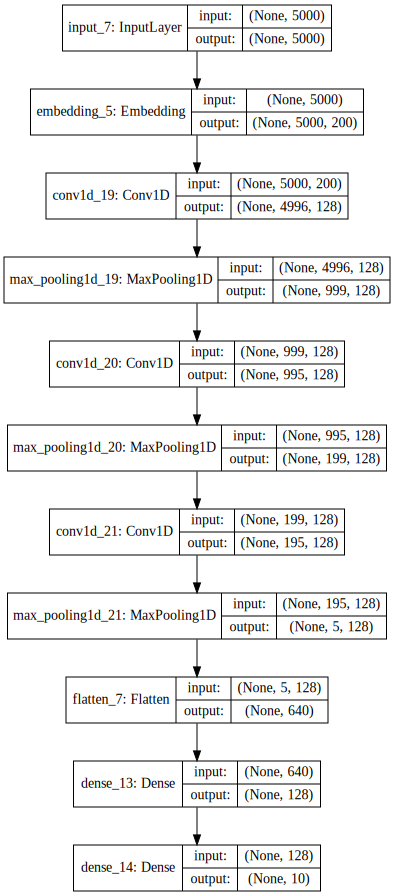

In [79]:
from keras.utils import plot_model
import pydot
pydot.find_graphviz = lambda: True

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [80]:
# split data into train and test
data_tr = data[0:3321,:]
data_ts = data[3321:,:]

In [81]:
# split the data into a training set and a validation set
indices = np.arange(data_tr.shape[0])
np.random.shuffle(indices)
data_tr = data_tr[indices]
labels = train[['Class']].values
labels = to_categorical(np.asarray(labels))
labels = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * data_tr.shape[0])

In [82]:
x_tr = data_tr[:-num_validation_samples]
y_tr = labels[:-num_validation_samples]
x_vl = data_tr[-num_validation_samples:]
y_vl = labels[-num_validation_samples:]

In [83]:
print num_validation_samples
print x_tr.shape
print y_tr.shape
print x_vl.shape
print y_vl.shape

664
(2657, 5000)
(2657, 10)
(664, 5000)
(664, 10)


In [84]:
K.set_value(model.optimizer.lr, 0.0001)
model.fit(x_tr, y_tr,
          batch_size=64,
          epochs=10,
          validation_data=(x_vl, y_vl))

Train on 2657 samples, validate on 664 samples
Epoch 1/10
2657/2657 [==============================] - 137s - loss: 1.9894 - acc: 0.2710 - val_loss: 1.8337 - val_acc: 0.3042
Epoch 2/10
2657/2657 [==============================] - 140s - loss: 1.7742 - acc: 0.3384 - val_loss: 1.7593 - val_acc: 0.3163
Epoch 3/10
2657/2657 [==============================] - 143s - loss: 1.6975 - acc: 0.3846 - val_loss: 1.6851 - val_acc: 0.3810
Epoch 4/10
2657/2657 [==============================] - 152s - loss: 1.6328 - acc: 0.4257 - val_loss: 1.6564 - val_acc: 0.3313
Epoch 5/10
2657/2657 [==============================] - 150s - loss: 1.5731 - acc: 0.4562 - val_loss: 1.5790 - val_acc: 0.4127
Epoch 6/10
2657/2657 [==============================] - 143s - loss: 1.5031 - acc: 0.5036 - val_loss: 1.5327 - val_acc: 0.4172
Epoch 7/10
2657/2657 [==============================] - 154s - loss: 1.4378 - acc: 0.5299 - val_loss: 1.4696 - val_acc: 0.4940
Epoch 8/10
2657/2657 [==============================] - 153s - l

In [85]:
K.set_value(model.optimizer.lr, 0.00001)
model.fit(x_tr, y_tr,
          batch_size=64,
          epochs=10,
          validation_data=(x_vl, y_vl))

Train on 2657 samples, validate on 664 samples
Epoch 1/10
2657/2657 [==============================] - 130s - loss: 1.2002 - acc: 0.6206 - val_loss: 1.2963 - val_acc: 0.5617
Epoch 2/10
2657/2657 [==============================] - 136s - loss: 1.1835 - acc: 0.6349 - val_loss: 1.2935 - val_acc: 0.5648
Epoch 3/10
2657/2657 [==============================] - 141s - loss: 1.1790 - acc: 0.6421 - val_loss: 1.2906 - val_acc: 0.5648
Epoch 4/10
2657/2657 [==============================] - 143s - loss: 1.1734 - acc: 0.6428 - val_loss: 1.2856 - val_acc: 0.5633
Epoch 5/10
2657/2657 [==============================] - 126s - loss: 1.1689 - acc: 0.6443 - val_loss: 1.2812 - val_acc: 0.5708
Epoch 6/10
2657/2657 [==============================] - 131s - loss: 1.1639 - acc: 0.6526 - val_loss: 1.2809 - val_acc: 0.5617
Epoch 7/10
2657/2657 [==============================] - 137s - loss: 1.1597 - acc: 0.6428 - val_loss: 1.2828 - val_acc: 0.5602
Epoch 8/10
2657/2657 [==============================] - 142s - l

In [86]:
K.set_value(model.optimizer.lr, 0.000005)
model.fit(x_tr, y_tr,
          batch_size=64,
          epochs=10,
          validation_data=(x_vl, y_vl))

Train on 2657 samples, validate on 664 samples
Epoch 1/10
2657/2657 [==============================] - 149s - loss: 1.1425 - acc: 0.6635 - val_loss: 1.2684 - val_acc: 0.5633
Epoch 2/10
2657/2657 [==============================] - 151s - loss: 1.1404 - acc: 0.6624 - val_loss: 1.2652 - val_acc: 0.5663
Epoch 3/10
2657/2657 [==============================] - 149s - loss: 1.1381 - acc: 0.6583 - val_loss: 1.2641 - val_acc: 0.5663
Epoch 4/10
2657/2657 [==============================] - 150s - loss: 1.1363 - acc: 0.6601 - val_loss: 1.2634 - val_acc: 0.5663
Epoch 5/10
2657/2657 [==============================] - 153s - loss: 1.1348 - acc: 0.6632 - val_loss: 1.2602 - val_acc: 0.5723
Epoch 6/10
2657/2657 [==============================] - 153s - loss: 1.1321 - acc: 0.6639 - val_loss: 1.2635 - val_acc: 0.5633
Epoch 7/10
2657/2657 [==============================] - 151s - loss: 1.1305 - acc: 0.6605 - val_loss: 1.2579 - val_acc: 0.5708
Epoch 8/10
2657/2657 [==============================] - 151s - l

In [87]:
K.set_value(model.optimizer.lr, 0.000001)
model.fit(x_tr, y_tr,
          batch_size=64,
          epochs=10,
          validation_data=(x_vl, y_vl))

Train on 2657 samples, validate on 664 samples
Epoch 1/10
2657/2657 [==============================] - 152s - loss: 1.1216 - acc: 0.6654 - val_loss: 1.2540 - val_acc: 0.5723
Epoch 2/10
2657/2657 [==============================] - 154s - loss: 1.1211 - acc: 0.6647 - val_loss: 1.2536 - val_acc: 0.5723
Epoch 3/10
2657/2657 [==============================] - 143s - loss: 1.1210 - acc: 0.6696 - val_loss: 1.2536 - val_acc: 0.5723
Epoch 4/10
2657/2657 [==============================] - 147s - loss: 1.1202 - acc: 0.6658 - val_loss: 1.2535 - val_acc: 0.5723
Epoch 5/10
2657/2657 [==============================] - 146s - loss: 1.1199 - acc: 0.6665 - val_loss: 1.2533 - val_acc: 0.5738
Epoch 6/10
2657/2657 [==============================] - 146s - loss: 1.1196 - acc: 0.6680 - val_loss: 1.2531 - val_acc: 0.5738
Epoch 7/10
2657/2657 [==============================] - 150s - loss: 1.1193 - acc: 0.6684 - val_loss: 1.2523 - val_acc: 0.5708
Epoch 8/10
2657/2657 [==============================] - 146s - l

In [88]:
l = train[['Class']].values

In [104]:
x = to_categorical(l-1)

In [106]:
x.shape

(3321, 9)